# Practical task. Kernelized k-means.

In this task you will get a brief introduction into K-means clustering, its limitations and kernel-trick 

Firstly, install package Pillow and import listed libraries.

In [ ]:
!pip install Pillow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.cluster import KMeans
np.random.seed(20)
%matplotlib inline

Another great tool which is required for this task is KernelKmeans implementation. Luckily you shouldn't design it by yourselves. Everything you need is just executing next cell to have an opportunity to use it further.

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state


class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    Kernel K-means
    
    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="linear", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose
        
    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change 
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print ("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the 
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)

To solve a typical problem let's generate a synthetic dataset which is called "blob".

In [3]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(300, factor=.1, noise=.1)

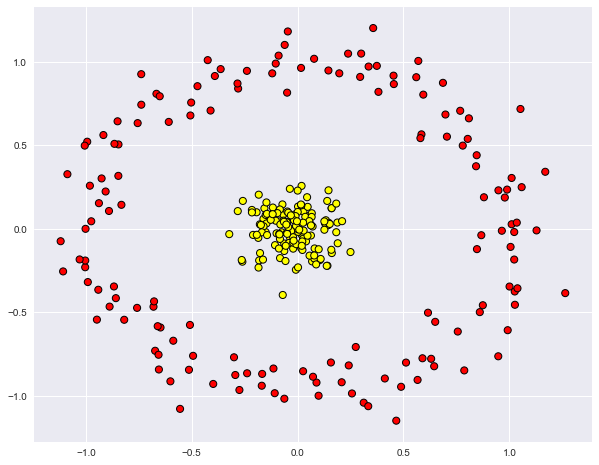

In [4]:
plt.rcParams["figure.figsize"] = (10,8)
ax =plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn',linewidth=1.0, edgecolor="black")

As you may see, the dataset consist of 2 classes which are not linearly separable.
You may remember that one of the limitation of classical K-Means algorithm is that it doesn't work with such type of data. 
To prove it execute next cell and check the results.

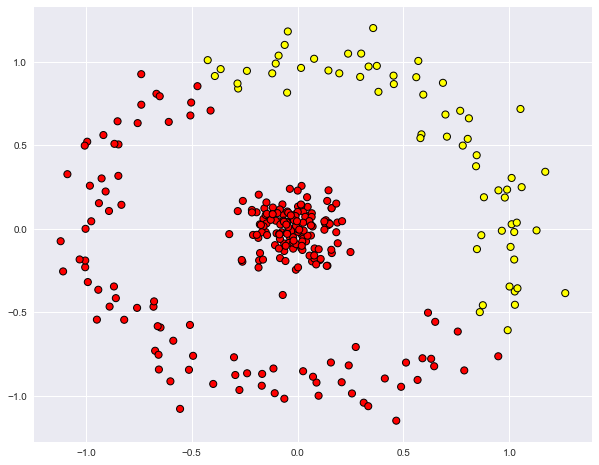

In [5]:
clf=KMeans(n_clusters=2)
clf.fit(X,y)
plt.rcParams["figure.figsize"] = (10,8)
ax =plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=clf.predict(X), s=50, cmap='autumn',linewidth=1.0, edgecolor="black")

Question 1: Explain in your own words why K-Means doesn't work in this case?

Answer:

### ---------------------------------------------------------------------------------

To get rid of these limitations let's map our data from R2 space to R3 using custom kernel and visualize the results.

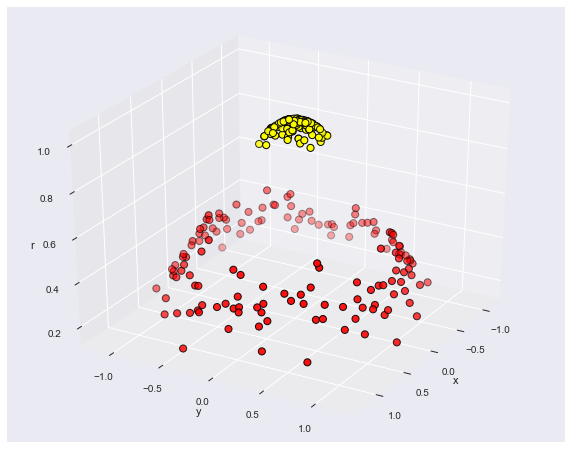

In [137]:
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d


def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], np.exp(-(X ** (2)).sum(1)), c=y, s=50, cmap='autumn',linewidth=1.0, edgecolor="black")
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

# interact(plot_3D, elev=(-90, 90), azip=(-180, 180),
#          X=fixed(X), y=fixed(y));
plot_3D()

Question 2: Describe our custom kernel and apply it for the 5th point in our dataset (write down the formula for the new dimension and append new point coordinates as an example)    

Answer:

### ---------------------------------------------------------------------------------

Finally, use kernelized k-means and check the results. NB: Unfortunately clustering algorithms are not stable therefore you have to rerun the algorithm until you get the desired result. If you don't get it, change "KernelKmeans" to "KMeans" and pass init=np.array([[0,0,0],[0,0,1]]) as a parameter

In [7]:
r = np.exp(-(X ** (2)).sum(1))

C:\Users\Maksim.Ostroukhov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


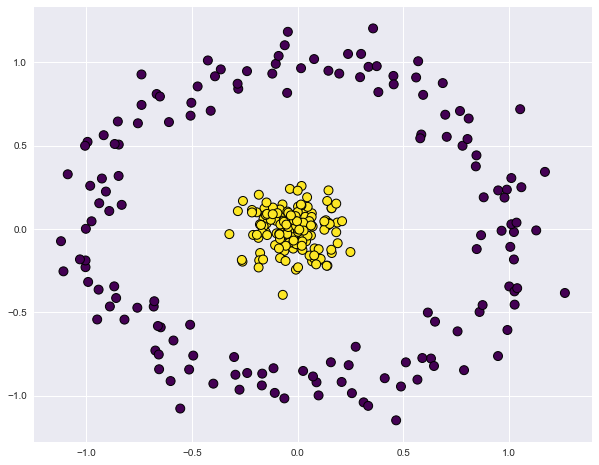

In [134]:
clf_k=KernelKMeans(n_clusters=2)
clf_k.fit(np.append(X,[[x] for x in r],axis=1))
plt.scatter(X[:, 0], X[:, 1], c=clf_k.predict((np.append(X,[[x] for x in r],axis=1))), s=80, cmap='viridis',linewidth=1.0, edgecolor="black")

Question 3: Describe the results of the algorithm and explain why does it work now?     

Answer: